# Análise da actividade parlamentar das XIV Legislatura: Dezembro de 2020

## Introdução

**Este bloco de notas é uma actualização ao trabalho inicial que pode ser acedido pelos atalhos acima e que descreve de forma detalhada todas as opções, com visibilidade de todo o código, explicação dos algoritmos utilizados e todo o processo de tratamento e exploração de dados; cobre toda a legistlatura até ao fim de 2020, cobrindo assim a votação do Orçamento de Estado - a versão inicial foi feita antes dessas votações.**

O posicionamento absoluto e relativo dos vários partidos políticos no Parlamento português tem sido motivo de interesse redobrado nos últimos anos. A eleição de deputados de partidos sem anterior presença parlamentar tem alimentado o debate cujas implicações ideológicas foram vísiveis de forma bastante prática na problemática em torno da escolha de lugares: partidos desagradados com o lugar atribuído (“Iniciativa Liberal Descontente Com Lugar Atribuído a Deputado No Parlamento - TSF” 2020), dificuldades gerais em termos de arrumação dos deputados (Renascença 2019), questões de ordem mais ou menos prática em torno de acessos (Almeida 2019), enfim, várias dimensões para uma questão que acaba por revelar a importância simbólica do posicionamento absoluto e relativo de cada partido no hemiciclo.

Esta questão não é particularmente nova (Lourenço 2020), colocando-se em maior ou em menor grau com a entrada de novos partidos e a consequente necessidade de tomada de posição por parte do recém-chegado partido e a harmonização (possível) com os restantes, sendo que a sua posterior actividade parlamentar (nas suas diversas vertentes) poderá ou não alinhar-se com a sua auto-identificação (reflectida ou não nos lugares no hemiciclo).

O ponto de partida para esta análise foi precisamente tentar descobrir se exclusivamente com base na actividade parlamentar, e em concreto no registo de votações, é possível estabelecer relações de proximidade e distância que permitam um agrupamento que não dependa de classificações a priori, e se sim, de que forma estes agrupamentos confirmam ou divergem da percepção existente?

A utilização de dados abertos disponibilizados pelo Parlamento torna esta análise substancialmente mais simples, embora não sem a necessidade de tratamento e validação dos dados; de um ponto de vista prático este bloco de notas demonstra como aceder e transformar os dados de uma forma que pode ser útil para outras análises. No cenário nacional referência para a iniciativa http://hemiciclo.pt que, em linha com iniciativas europeias semelhantes, fornecesse um interface para um maior escrutinio da actividade parlamentar e um conjunto alargado de indicadores directos e indirectos do maior interesse (Sapage 2020). O presente trabalho tem alguns pontos de contacto com esta iniciativa, dentro dos limites que o seu objectivo pedagógico estabelece.

A combinação de dados abertos com um bloco de notas Jupyter permite que o leitor tenha visibilidade dos vários passos e transformações (Randles et al. 2017), o que pode por vezes apresentar uma excessiva complexidade para quem não tenha familiaridade com programação; tentámos obviar esta limitação através da descrição das várias acções de forma a que se possa seguir a lógica e fruir dos resultados. Esta transparência assume uma dimensão adicional tendo em conta a temática que nos proposmos analisar, embora seja importante de forma tranversal (sobre a importância da repetibilidade, rastreabilidade, acesso e o papel de blocos Jupyter no contexto de open science ver, entre outros, exemplos em ecologia (Powers and Hampton 2019) astronomia (Wofford et al. 2019)).



## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML [DadosAbertos] são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos).

São fundamentalmente feitas as seguintes análises:

1. Vista geral das votações de cada partido, visualizado através de um _heatmap_
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)


O tratamento prévio dos dados em formato XML é feito de forma a seleccionar as votações de cada partido (ou deputado não inscrito); este processo tem alguma complexidade que se prende com o próprio processo de votação parlamentar, com múltiplas sessões e votações, pelo que foram 

De forma acessória são também feitas algumas análises adicionais, já mais removidas do objectivo central de determinação do distânciamento mas que complementam o quadro geral do que é possível.

## Obtenção e tratamento dos dados

Esta fase é fundamental para toda a restante análise: é onde obtemos os dados e os transformamos em informação num formato que pode ser facilmente manipulado.

In [41]:
!pip3 install --user -q itables matplotlib pandas bs4 html5lib lxml seaborn sklearn pixiedust

%matplotlib inline

from itables import show
import itables.options as opt

opt.maxColumns=100
opt.maxRows=2000
opt.lengthMenu = [10, 20, 50, 100, 200, 500]


## Obtenção do ficheiro e conversão para dataframe

In [3]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

ini_url = 'http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394a626d6c6a6157463061585a68637939595356596c4d6a424d5a57647063327868644856795953394a626d6c6a6157463061585a686331684a566935346257773d&fich=IniciativasXIV.xml&Inline=true'
ini_tree = ET.parse(urlopen(ini_url))

In [4]:
from bs4 import BeautifulSoup
import re

## Iteract through the existing dict
def party_from_votes (votes):
    """
    Determines the position of a party based on the majority position by summing all the individual votes.
    Argument is a dictionary returned by parse_voting()
    Returns a dictionary with the majority position of each party
    """
    party_vote = {}
    for k, v in votes.items():
        ## Erase the name of the MP and keep the party only
        ## only when it's not from the "Ninsc" group - 
        ## these need to be differentiated by name
        if re.match(".*\(Ninsc\)" , k) is None:
            nk = re.sub(r".*\((.+?)\).*", r"\1", k)
        else:
            nk = k
        ## If it's the first entry for a key, create it
        if nk not in party_vote:
            party_vote[nk] = [0,0,0]
        ## Add to a specific index in a list
        if v == "A Favor":
            party_vote[nk][0] += 1
        elif v == "Abstenção":
            party_vote[nk][1] += 1
        elif v == "Contra":
            party_vote[nk][2] += 1
    for k,v in party_vote.items():
        party_vote[k]=["A Favor", "Abstenção", "Contra"][v.index(max(v))]
    return party_vote

def parse_voting(v_str):
    """Parses the voting details in a string and returns a dict.
    
    Keyword arguments:
    
    v_str: a string with the description of the voting behaviour.
    """
    ## Split by the HTML line break and put it in a dict
    d = dict(x.split(':') for x in v_str.split('<BR>'))
    ## Remove the HTML tags
    for k, v in d.items():
        ctext = BeautifulSoup(v, "lxml")
        d[k] = ctext.get_text().strip().split(",")
    ## Invert the dict to get a 1-to-1 mapping
    ## and trim it
    votes = {}
    if len(v_str) < 1000:    # Naive approach but realistically speaking... works well enough.
        for k, v in d.items():
            for p in v:
                if (p != ' ' and                                       # Bypass empty entries
                    re.match("[0-9]+", p.strip()) is None and           # Bypass quantified divergent voting patterns
                    (re.match(".*\w +\(.+\)", p.strip()) is None or     # Bypass individual votes...
                     re.match(".*\(Ninsc\)" , p.strip()) is not None)): # ... except when coming from "Ninsc"
                        #print("|"+ p.strip() + "|" + ":\t" + k)
                        votes[p.strip()] = k
    else:  # This is a nominal vote since the size of the string is greater than 1000
        for k, v in d.items():
            for p in v:
                if p != ' ':
                    votes[p.strip()] = k
        ## Call the auxiliary function to produce the party position based on the majority votes
        votes = party_from_votes(votes)
    return votes

In [5]:
import collections

root = ini_tree

counter=0

## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
init_list = []

for voting in ini_tree.findall(".//pt_gov_ar_objectos_VotacaoOut"):
    votep = voting.find('./detalhe')
    if votep is not None:
        init_dict = collections.OrderedDict()
        counter +=1                 
        init_dict['id'] = voting.find('id').text
        ## Add the "I" for Type to mark this as coming from "Iniciativas"
        init_dict['Tipo'] = "I"
        for c in voting:
            if c.tag == "detalhe":
                for party, vote in parse_voting(c.text).items():
                    init_dict[party] = vote 
            elif c.tag == "descricao":
                    init_dict[c.tag] = c.text
            elif c.tag == "ausencias":
                    init_dict[c.tag] = c.find("string").text
            else:
                    init_dict[c.tag] = c.text
        init_list.append(init_dict)
    ## Provide progression feedback
    print('.', end='')
        
print(counter)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [44]:
import pandas as pd

ini_df = pd.DataFrame(init_list)
#print(ini_df.shape)
#ini_df.head()


In [45]:
## Copy Livre voting record to new aggregate columns...
ini_df["L/JKM"] = ini_df["L"]
## ... and fill the NAs with JKM voting record.
#ini_df["L/JKM"] = ini_df["L/JKM"].fillna(ini_df["Joacine Katar Moreira (Ninsc)"])
#ini_df[["descricao","L","Joacine Katar Moreira (Ninsc)","L/JKM"]]

In [46]:
## Copy PAN voting record to new aggregate columns...
ini_df["PAN/CR"] = ini_df["PAN"]
## ... and update/replace with CR voting where it exists
#ini_df["PAN/CR"].update(ini_df["Cristina Rodrigues (Ninsc)"])
#ini_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]]


## Actividades

In [9]:
act_url = 'http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379394264476c32615752685a47567a4c31684a566955794d45786c5a326c7a6247463064584a684c30463061585a705a47466b5a584e595356597565473173&fich=AtividadesXIV.xml&Inline=true'
act_tree = ET.parse(urlopen(act_url))

In [10]:
import re
import collections

root = act_tree

counter=0

## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
act_list = []

def get_toplevel_desc (vid, tree):
    """
    Gets the top-level title from a voting id
    """
    for c in tree.find(".//pt_gov_ar_objectos_VotacaoOut/[id='"+ vid +"']/../.."):
        if c.tag == "assunto":
            return c.text

for voting in act_tree.findall(".//pt_gov_ar_objectos_VotacaoOut"):
    act_dict = collections.OrderedDict()
    counter +=1
    votep = voting.find('./detalhe')
    if votep is not None:
        act_dict['id'] = voting.find('id').text
        ## Add the "A" for Type to mark this as coming from "Iniciativas"
        act_dict['Tipo'] = "A"
        for c in voting:
            if c.tag == "id":
                act_dict['descricao'] = get_toplevel_desc(c.text, act_tree)
            if c.tag == "detalhe":
                for party, vote in parse_voting(c.text).items():
                    act_dict[party] = vote 
            elif c.tag == "ausencias":
                    act_dict[c.tag] = c.find("string").text
            else:
                    act_dict[c.tag] = c.text
        act_list.append(act_dict)
    ## Provide progression feedback
    print('.', end='')

print(counter)

............................................................................................................................................................................................................................................................................268


In [48]:
act_df = pd.DataFrame(act_list)
#print(act_df.shape)

#act_df.head()

In [49]:
## Copy Livre voting record to new aggregate columns...
act_df["L/JKM"] = act_df["L"]
## ... and fill the NAs with JKM voting record.
act_df["L/JKM"] = act_df["L/JKM"].fillna(act_df["Joacine Katar Moreira (Ninsc)"])

## Copy PAN voting record to new aggregate columns...
act_df["PAN/CR"] = act_df["PAN"]
## ... and update/replace with CR voting where it exists
act_df["PAN/CR"].update(act_df["Cristina Rodrigues (Ninsc)"])
#act_df[["descricao","PAN","Cristina Rodrigues (Ninsc)","PAN/CR"]].head()

In [13]:
votes = pd.concat([ini_df.drop(["tipoReuniao"],axis=1),act_df.drop(["data","publicacao"],axis=1)], sort=True)

In [50]:
votes_hm = votes[['BE', 'PCP', 'PEV', 'L/JKM', 'PS', 'PAN','PSD','IL','CDS-PP', 'CH']]
#votes_hm.head()

## Mapa térmico

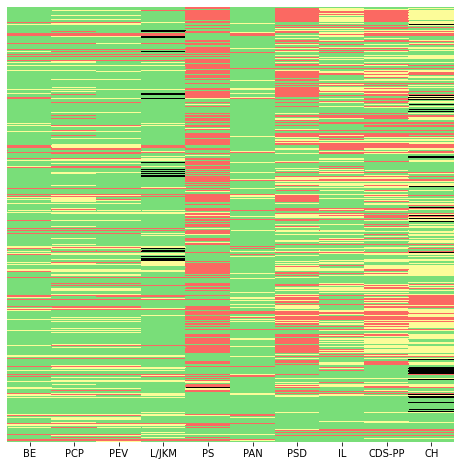

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,2]).fillna(0)

voting_palette = ["#FB6962","#FCFC99","#79DE79", "black"]

fig = plt.figure(figsize=(8,8))
sns.heatmap(votes_hmn,
            square=False,
            yticklabels = False,
            cbar=False,
            cmap=sns.color_palette(voting_palette),
           )
plt.show()

## Quem vota com quem

Com estes dados podemos tentar obter uma resposta mais clara do que o "mapa térmico" anterior nos apresenta como sendo semelhanças e diferenças no registo de votação.

Uma das questões que se coloca (e normalmente coloca-se com maior ênfase sempre que há uma votação que é apontada como sendo "atípica", com base na percepção geral do que é o comportamente de voto habitual de cada partido) é saber "quem vota com quem". Estes dados podem ser obtidos através da identificação, para cada partido, da quantidade de votações onde cada outro votou da mesma forma e criação de uma tabela com os resultados:

In [16]:
import numpy as np
pv_list = []
print("Total voting instances: ", votes_hm.shape[0])

## Not necessarily the most straightforard way (check .crosstab or .pivot_table, possibly with pandas.melt and/or groupby)
## but follows the same approach as before in using a list of dicts
for party in votes_hm.columns:
    pv_dict = collections.OrderedDict()
    for column in votes_hmn:
        pv_dict[column]=votes_hmn[votes_hmn[party] == votes_hmn[column]].shape[0]
    pv_list.append(pv_dict)

pv = pd.DataFrame(pv_list,index=votes_hm.columns)
pv

Total voting instances:  2457


,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,2457,1973,2031,2047,1189,1851,1121,1204,1106,1110
PCP,1973,2457,2326,1819,1157,1577,1093,1176,1100,1093
PEV,2031,2326,2457,1879,1143,1661,1066,1184,1051,1069
L/JKM,2047,1819,1879,2457,1084,1762,1037,1174,1030,1040
PS,1189,1157,1143,1084,2457,1214,1641,1220,1287,912
PAN,1851,1577,1661,1762,1214,2457,1248,1373,1209,1171
PSD,1121,1093,1066,1037,1641,1248,2457,1471,1723,1344
IL,1204,1176,1184,1174,1220,1373,1471,2457,1561,1476
CDS-PP,1106,1100,1051,1030,1287,1209,1723,1561,2457,1525
CH,1110,1093,1069,1040,912,1171,1344,1476,1525,2457


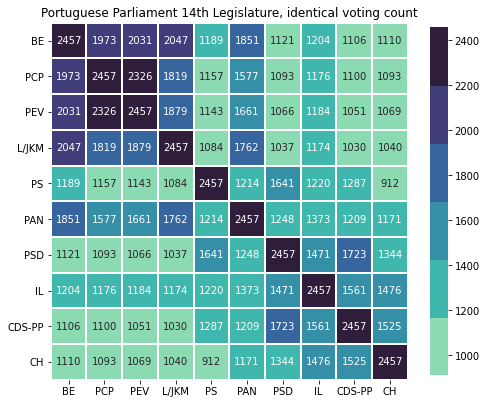

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    pv,
    cmap=sns.color_palette("mako_r"),
    linewidth=1,
    annot = True,
    square =True,
    fmt="d",
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 14th Legislature, identical voting count')

plt.show()

## Matriz de distância

Com base nos histórico de votações de cada partido produzimos uma matriz de distâncias entre eles; uma matriz de distâncias é uma matriz quadradra $n\times n$ (onde _n_ é o número de partidos) e onde a distância entre _p_ e _q_ é o valor de $ d_{pq} $.

$ 
\begin{equation}
D= \begin{bmatrix} d_{11} & d_{12} & \cdots & d_{1 n} \\  d_{21} & d_{22} & \cdots & d_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ d_{31} & d_{32} & \cdots & d_{n n}   \end{bmatrix}_{\ n\times n}  
\end{equation}
$


A distância é obtida através da comparação de todas as observações de cada par usando uma determinada métrica de distância, sendo a distância euclideana bastante comum em termos gerais e também dentro de estudos sobre o mesmo domínio temático _(Krilavičius and Žilinskas 2008)_: cada elemento da matriz representa $ d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$, equivalente, para dois pontos $P,Q $ , à mais genérica distância de Minkowski   $ D\left(P,Q\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{\frac {1}{p}} $ para $ p = 1$, mas note-se que a diagonal da matrix irá representar a distância entre um partido e ele próprio, logo $ d_{11} = d_{22} = \dots = d_{nn} = 0 $.

Na secção  [Distâncias e matrizes](Distâncias_e_matrizes) colocámos uma discussão mais detalhada (mas passo-a-passo e destinada a quem não tenha necessariamente presente a matemática utilizada) sobre distâncias, _clustering_ e como são calculdadas, para quem tenha interesse numa compreensão mais quantitativa da matéria.

A conversão de votos em representações númericas pode ser feita de várias formas _(Hix, Noury, and Roland 2006)_; adoptamos a abordagem de Krilavičius & Žilinskas (2008) no já citado  trabalho relativo às votações no parlamento lituano por nos parecer apropriada à realidade portuguesa:

* A favor: 1
* Contra: -1
* Abstenção: 0
* Ausência: 0

Este ponto é (mais um) dos que de forma relativamente opaca - pois raramente os detalhes têm a mesma projecção que os resultado finais - podem influenciar os resultados; cremos que em particular a equiparação entre _abstenção_ e _ausência_ merece alguma reflexão: considerámos que uma ausência em determinada votação tem um peso equivalente à abstenção, embora uma de forma passiva e outra activa.

Para obtermos a matriz de distância usamos a função `pdist` e construímos um _dataframe_ que é uma matriz simétrica das distâncias entre os partidos.

In [20]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from itables import show

votes_hmn = votes_hm.replace(["A Favor", "Contra", "Abstenção", "Ausência"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)
#show(distmat, scrollY="200px", scrollCollapse=True, paging=False)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 
#distmat=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
distmat

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,0.000000,29.000000,25.573424,22.693611,63.553127,33.896903,61.343296,52.497619,56.877060,49.386233
PCP,29.000000,0.000000,15.066519,31.112698,60.232881,42.047592,58.189346,52.507142,54.424259,48.249352
PEV,25.573424,15.066519,0.000000,28.231188,61.506097,39.509493,59.640590,52.744668,56.115951,49.183331
L/JKM,22.693611,31.112698,28.231188,0.000000,62.912638,33.555923,60.016664,50.606324,55.731499,48.062459
PS,63.553127,60.232881,61.506097,62.912638,0.000000,62.817195,44.022721,54.506880,50.497525,56.727418
PAN,33.896903,42.047592,39.509493,33.555923,62.817195,0.000000,56.709788,47.191101,52.763624,46.432747
PSD,61.343296,58.189346,59.640590,60.016664,44.022721,56.709788,0.000000,43.943145,34.842503,43.058100
IL,52.497619,52.507142,52.744668,50.606324,54.506880,47.191101,43.943145,0.000000,36.565011,37.054015
CDS-PP,56.877060,54.424259,56.115951,55.731499,50.497525,52.763624,34.842503,36.565011,0.000000,34.263683
CH,49.386233,48.249352,49.183331,48.062459,56.727418,46.432747,43.058100,37.054015,34.263683,0.000000


In [39]:
## Display the heatmap of the distance matrix

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

sns.heatmap(
    distmat,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    annot = True,
    square =True,
    cbar_kws={"shrink": 0.8})
plt.title('Portuguese Parliament 14th Legislature, Distance Matrix')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

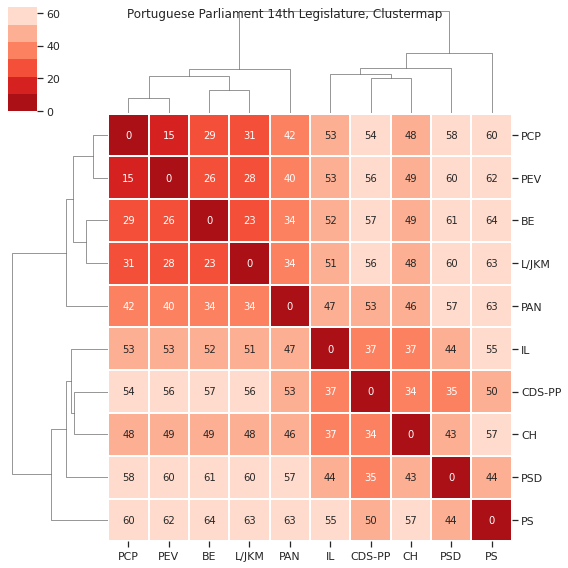

In [37]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 14th Legislature, Clustermap')

plt.show()

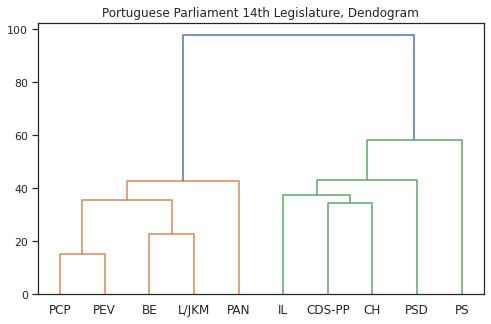

In [36]:
from scipy.cluster.hierarchy import dendrogram
fig = plt.figure(figsize=(8,5))
dendrogram(distmat_link, labels=votes_hmn.columns)

plt.title("Portuguese Parliament 14th Legislature, Dendogram")
plt.show()

## _Clustering_ de observações: DBSCAN e _Spectrum Scaling_


In [24]:
import numpy as np

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1
pd.DataFrame(distmat_mm, distmat.index, distmat.columns)

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,0.000000,0.456311,0.402394,0.357081,1.000000,0.533363,0.965229,0.826043,0.894953,0.777086
PCP,0.456311,0.000000,0.237070,0.489554,0.947756,0.661613,0.915602,0.826193,0.856358,0.759197
PEV,0.402394,0.237070,0.000000,0.444214,0.967790,0.621677,0.938437,0.829930,0.882977,0.773893
L/JKM,0.357081,0.489554,0.444214,0.000000,0.989922,0.527998,0.944354,0.796284,0.876928,0.756256
PS,1.000000,0.947756,0.967790,0.989922,0.000000,0.988420,0.692692,0.857659,0.794572,0.892598
PAN,0.533363,0.661613,0.621677,0.527998,0.988420,0.000000,0.892321,0.742546,0.830229,0.730613
PSD,0.965229,0.915602,0.938437,0.944354,0.692692,0.892321,0.000000,0.691440,0.548242,0.677513
IL,0.826043,0.826193,0.829930,0.796284,0.857659,0.742546,0.691440,0.000000,0.575346,0.583040
CDS-PP,0.894953,0.856358,0.882977,0.876928,0.794572,0.830229,0.548242,0.575346,0.000000,0.539134
CH,0.777086,0.759197,0.773893,0.756256,0.892598,0.730613,0.677513,0.583040,0.539134,0.000000


In [25]:
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)
affinmat_mm 

,BE,PCP,PEV,L/JKM,PS,PAN,PSD,IL,CDS-PP,CH
BE,1.000000,0.543689,0.597606,0.642919,0.000000,0.466637,0.034771,0.173957,0.105047,0.222914
PCP,0.543689,1.000000,0.762930,0.510446,0.052244,0.338387,0.084398,0.173807,0.143642,0.240803
PEV,0.597606,0.762930,1.000000,0.555786,0.032210,0.378323,0.061563,0.170070,0.117023,0.226107
L/JKM,0.642919,0.510446,0.555786,1.000000,0.010078,0.472002,0.055646,0.203716,0.123072,0.243744
PS,0.000000,0.052244,0.032210,0.010078,1.000000,0.011580,0.307308,0.142341,0.205428,0.107402
PAN,0.466637,0.338387,0.378323,0.472002,0.011580,1.000000,0.107679,0.257454,0.169771,0.269387
PSD,0.034771,0.084398,0.061563,0.055646,0.307308,0.107679,1.000000,0.308560,0.451758,0.322487
IL,0.173957,0.173807,0.170070,0.203716,0.142341,0.257454,0.308560,1.000000,0.424654,0.416960
CDS-PP,0.105047,0.143642,0.117023,0.123072,0.205428,0.169771,0.451758,0.424654,1.000000,0.460866
CH,0.222914,0.240803,0.226107,0.243744,0.107402,0.269387,0.322487,0.416960,0.460866,1.000000


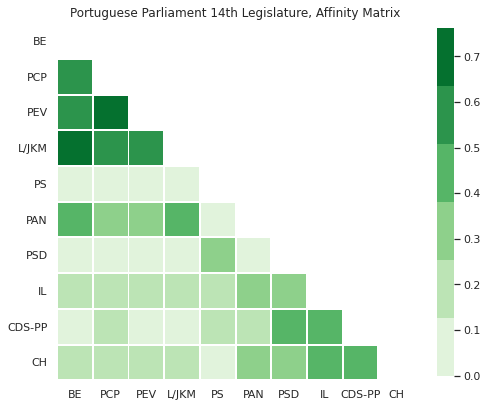

In [26]:
sns.set(style="white")

## Make the top triangle
mask = np.triu(np.ones_like(affinmat_mm, dtype=np.bool))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.title('Portuguese Parliament 14th Legislature, Affinity Matrix')

## Display the heatmap of the affinity matrix, masking the top triangle

sns.heatmap(
    affinmat_mm,
    cmap=sns.color_palette("Greens"),
    linewidth=1,
    annot = False,
    square =True,
    cbar_kws={"shrink": .8},
    mask=mask,linewidths=.5)

plt.show()

In [27]:
from sklearn.cluster import DBSCAN

dbscan_labels = DBSCAN(eps=1.1).fit(affinmat_mm)
dbscan_labels.labels_
dbscan_dict = dict(zip(distmat_mm,dbscan_labels.labels_))
dbscan_dict

{'BE': 0,
 'PCP': 0,
 'PEV': 0,
 'L/JKM': 0,
 'PS': 1,
 'PAN': 0,
 'PSD': 1,
 'IL': 1,
 'CDS-PP': 1,
 'CH': 1}

In [28]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

print(sc_dict)

{'BE': 2, 'PCP': 3, 'PEV': 3, 'L/JKM': 2, 'PS': 1, 'PAN': 2, 'PSD': 1, 'IL': 0, 'CDS-PP': 0, 'CH': 0}


### _Multidimensional scaling_ 

Até agora temos conseguido extrair informação interessante dos dados de votação:

1. O mapa térmico de votação permite-nos uma primeira visão do comportamente de todos os partidos. 
2. A matriz de distâncias fornece-nos uma forma de comparar as distâncias entre os diferentes partidos através de um mapa térmico.
3. O dendograma identifica de forma hierárquica agrupamentos.
4. Através de DBSCAN e _Spectrum Clustering_ identificamos "blocos" com base na matriz de afinidade.

Não temos ainda uma forma de visualizar a distância relativa de cada partido em relação aos outros com base nas distâncias/semelhanças: temos algo próximo com base no dendograma mas existem outras formas de visualização interessantes.

Uma das formas é o _multidimensional scaling_ que permite visualizar a distância ao projectar em 2 ou 3 dimensões (também conhecidas como _dimensões visualizavies_) conjuntos multidimensionais, mantendo a distância relativa _(“Graphical Representation of Proximity Measures for Multidimensional Data « The Mathematica Journal” 2020)_.

Como é habitual temos em Python, através da biblioteca `scikit-learn` (que já usámos para DBSCAN e _Spectrum Clustering_), uma implementação que podemos usar sem grande dificuldade _(“2.2. Manifold Learning — Scikit-Learn 0.23.2 Documentation” 2020)_.

In [29]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_
coords

array([[ 0.33299885,  0.36138221],
       [-0.00657669,  0.42473032],
       [ 0.10930041,  0.44054896],
       [ 0.39557388,  0.21339868],
       [-0.68909687,  0.15393775],
       [ 0.49318781, -0.08163115],
       [-0.51275165, -0.28664118],
       [ 0.14351589, -0.50188438],
       [-0.22776952, -0.48473615],
       [-0.03838211, -0.23910504]])

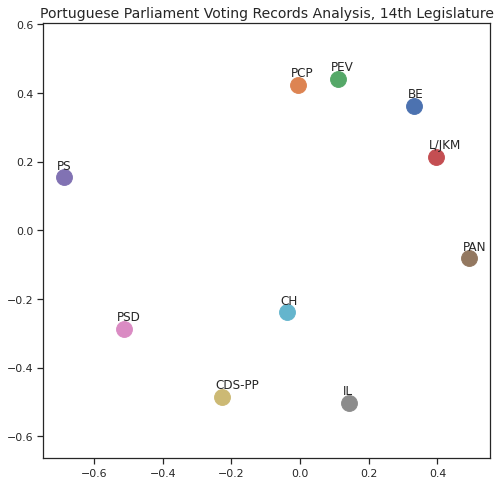

In [30]:
## Graphic options
sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))

plt.title('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))
plt.show()

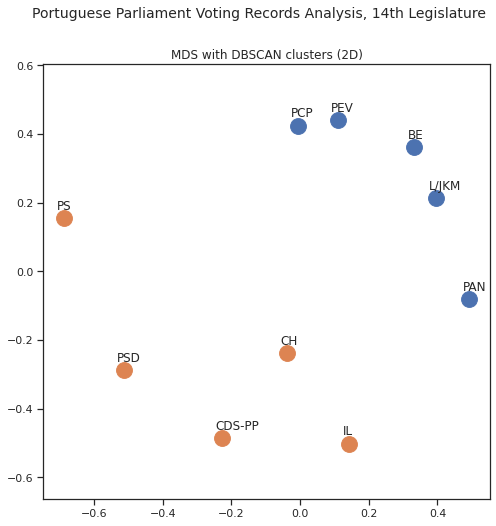

In [31]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(8,8))

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with DBSCAN clusters (2D)')

for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(dbscan_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

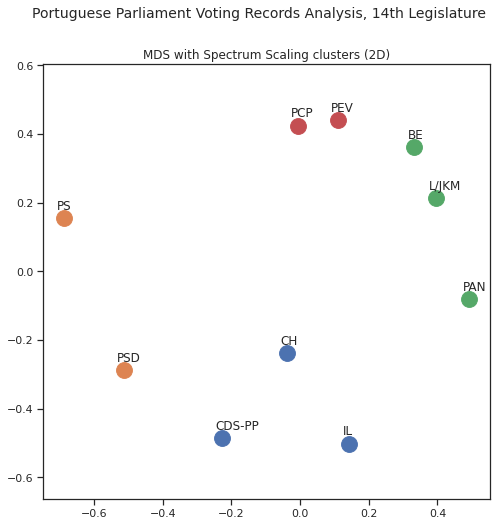

In [32]:
from sklearn.manifold import MDS
import random

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

In [33]:
## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot

from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)

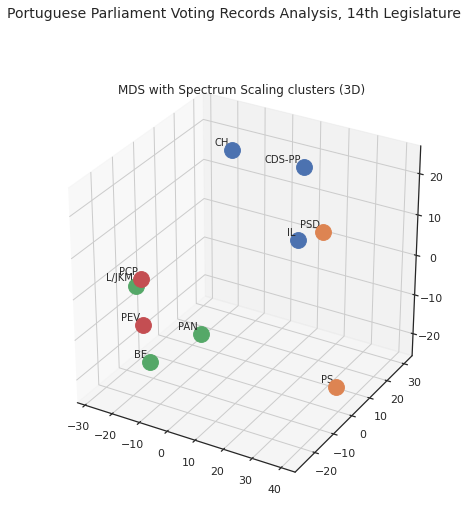

In [34]:
from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random

mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()
